# Spectral Parameterization

***

![voyteklab](./data/voyteklab.png)

***


## 02 - Real Data and Event-Related Analysis

Tutorial Authored by Eena Kosik. Edited by Sydney Smith and Quirine Van Engen.

<br><br>


Now that you've gotten some basic understanding of the algorithm itself, as well as how it can be applied on simulated data, let's apply what we've learned on **real data**. 

Instead of looking at multiple channels and subjects, we will be using *one* visual cortex intracranial channel in a person undergoing surgery for epilepsy. This is recorded using electrocorticography (ECoG), which is a grid structure that has multiple electrodes on the cortex of the brain (like you can visualize on the graphic below).

In this experiment, the subject was performing a visual stimulus task, in which they had to press a button if a target stimulus appeared on the screen. Therefore, this data is split up into three event types: standard stimuli (non-target), target stimuli, and the times the subject responded.

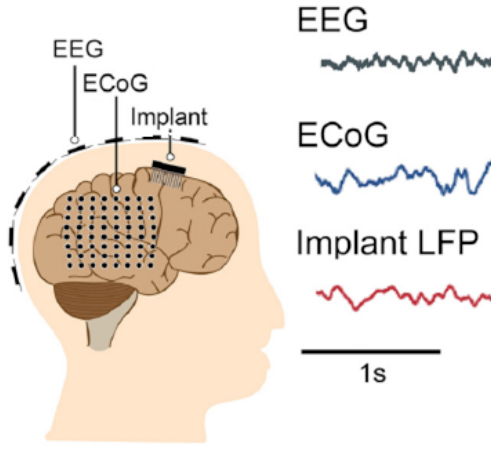

## Install necessary packages and clone repo (for Colab)

In [1]:
# Install necessary packages
!pip install neurodsp
!pip install fooof

# # Clone repo
# !git clone https://github.com/voytekresearch/spr.git
# %cd spr/tutorials/01_specparam

## Imports

In [2]:
# Standard python libraries
import numpy as np
import scipy.io as sio

# Neurodsp libraries
from neurodsp import spectral

# SpecParam (FOOOF) libraries 
from fooof import FOOOF, FOOOFGroup
from fooof.analysis import get_band_peak_fm, get_band_peak_fg

# Plotting imports
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina' # high res plotting


## Load Data

In [3]:
# We are setting the sampling frequency here. The data is sampled at 1000 Hz.
fs = 1000 

# Load the channel and the event indices.
data = sio.loadmat('data/ecog_data.mat', squeeze_me=True)
sta = data['sta'] # Standard event
tar = data['tar'] # Target event
resp = data['resp'] # Response times
data = data['data'] # Neural data from one ECoG channel

## Visualize Time Series Data

When we're looking at real data, it's always important to visualize each step of the way and ensure you understand the data. A good first step is plotting some of your time series data.

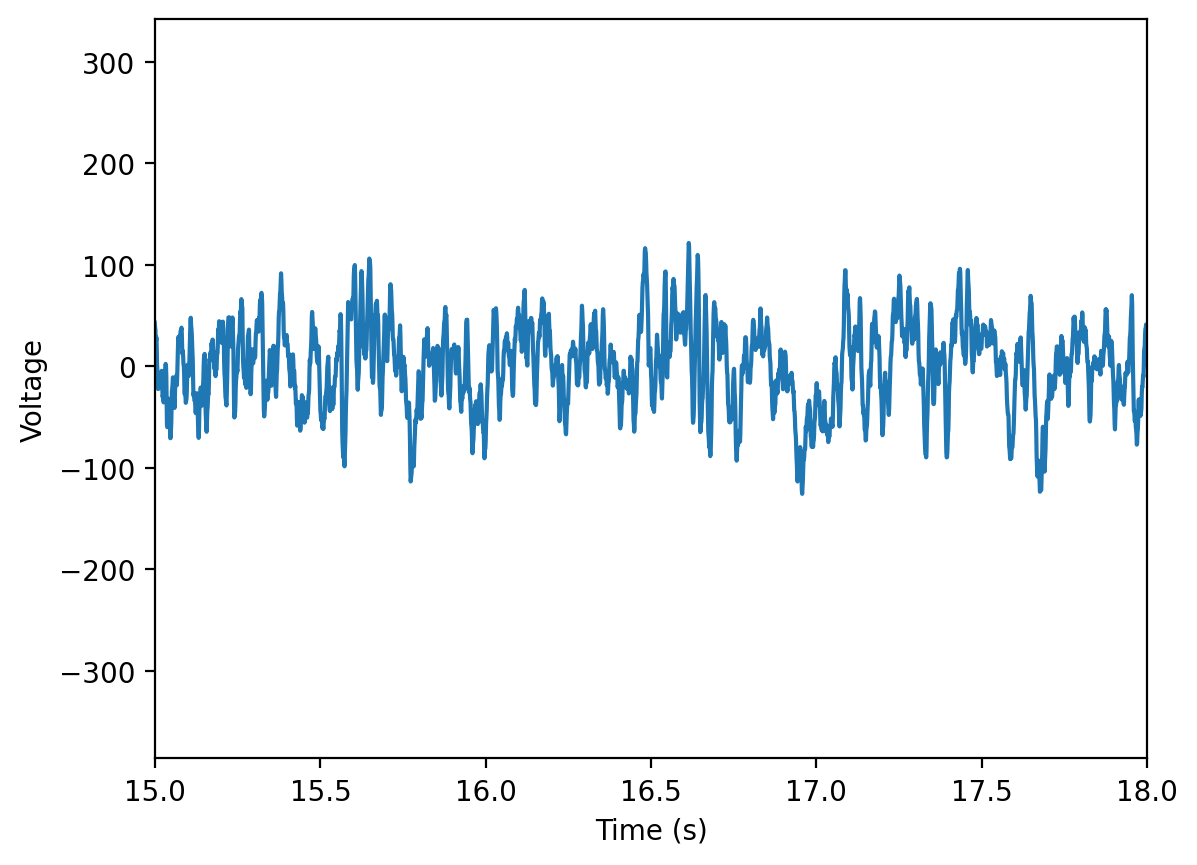

In [4]:
# Plot a section of the data in the time domain.
t = np.arange(len(data))/fs
plt.plot(t, data)
plt.xlim((15,18))
plt.xlabel('Time (s)')
plt.ylabel('Voltage')
plt.show()

## Compute and Plot Power Spectrum

Looking at the time series visually, you might be able to see some neural oscillations. However, to get a full sense of the data, you can compute the power spectrum to see how much power there is at each frequency band. 

We are using the `compute_spectrum` function through `neurodsp`, which by default uses Welch's method. This method computes the fast fourier transform (FFT) on windows of the data and averages the windowed FFT's to smooth out the power spectrum. 

In [5]:
# Compute power spectrum
freq, psd = spectral.compute_spectrum(data, fs=fs, method='welch', window='hann')

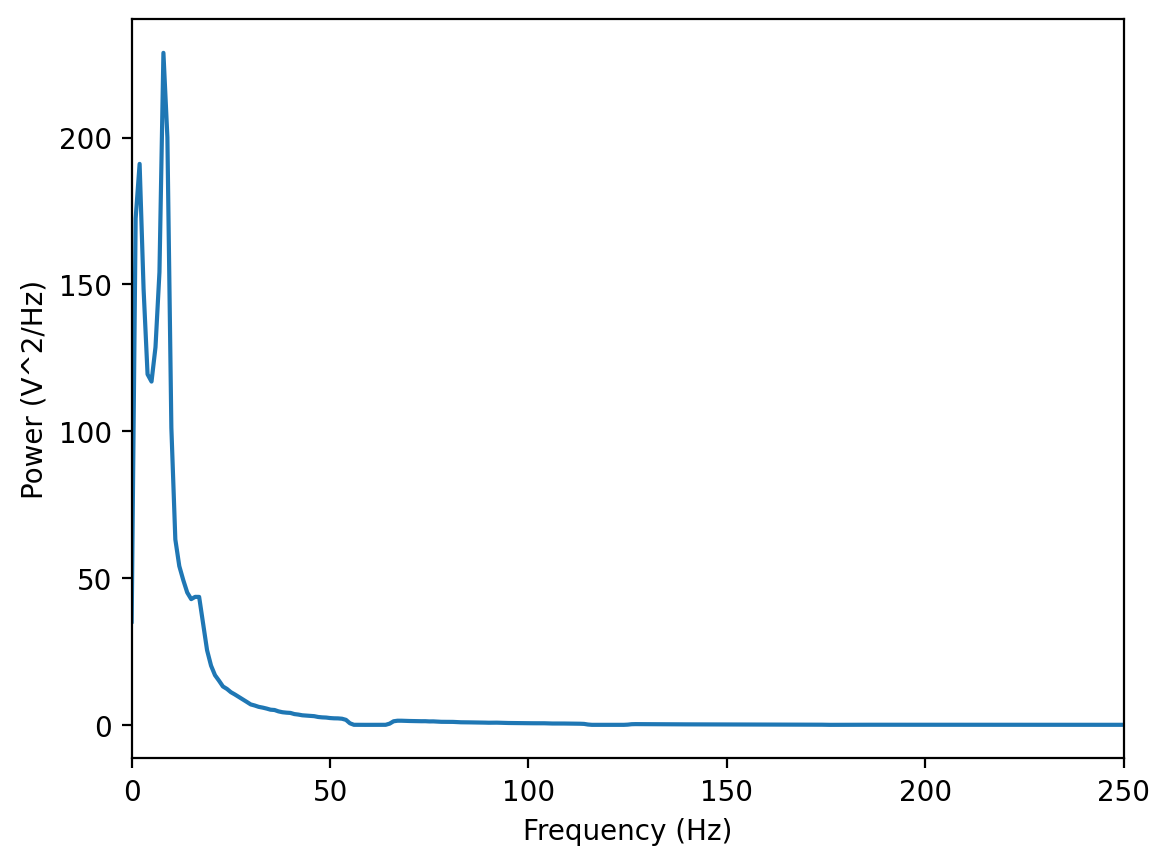

In [6]:
# Plot power spectrum
plt.plot(freq, psd)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power (V^2/Hz)')
plt.xlim((0, 250))
plt.show()

Here the "1/f" aspect of the data is clear: the lowest frequencies have exponentially higher power than the highest frequencies. We can't even see the power above ~100 Hz.

We can also see a huge burst of power at around 10 Hz. This is a very clear, strong, alpha oscillation in the visual cortex. We also see a little bump of power at around 20 Hz. But this might not be a "real" ~20 Hz beta oscillation, due to harmonic effects. This will be discussed more during the Bycycle notebooks.

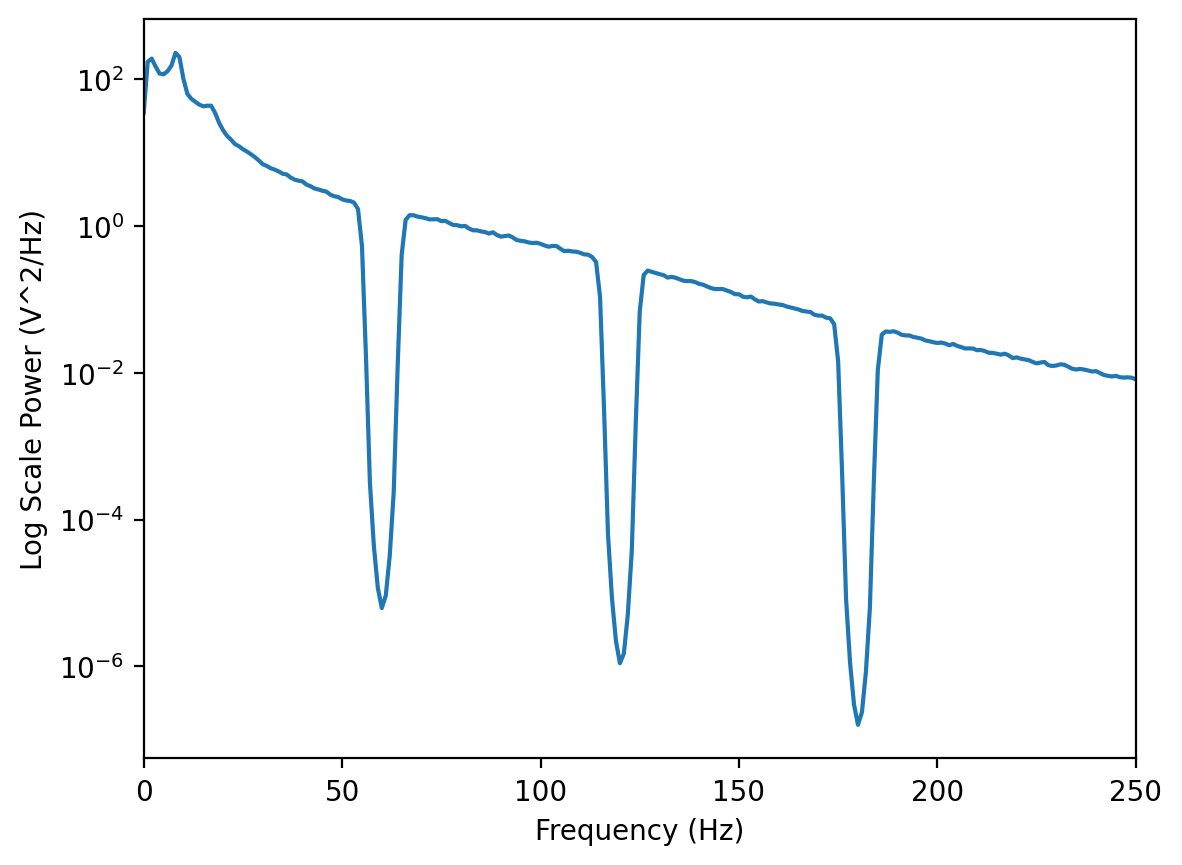

In [7]:
# Plot again, but log scale the power

plt.semilogy(freq, psd)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Log Scale Power (V^2/Hz)')
plt.xlim((0, 250))
plt.show()

Note that if we log-scale the power (y-axis) it starts to look like a straight line, except for the oscillatory bumps and the notch filters.

Let's zoom in on just the < 60 Hz regions...

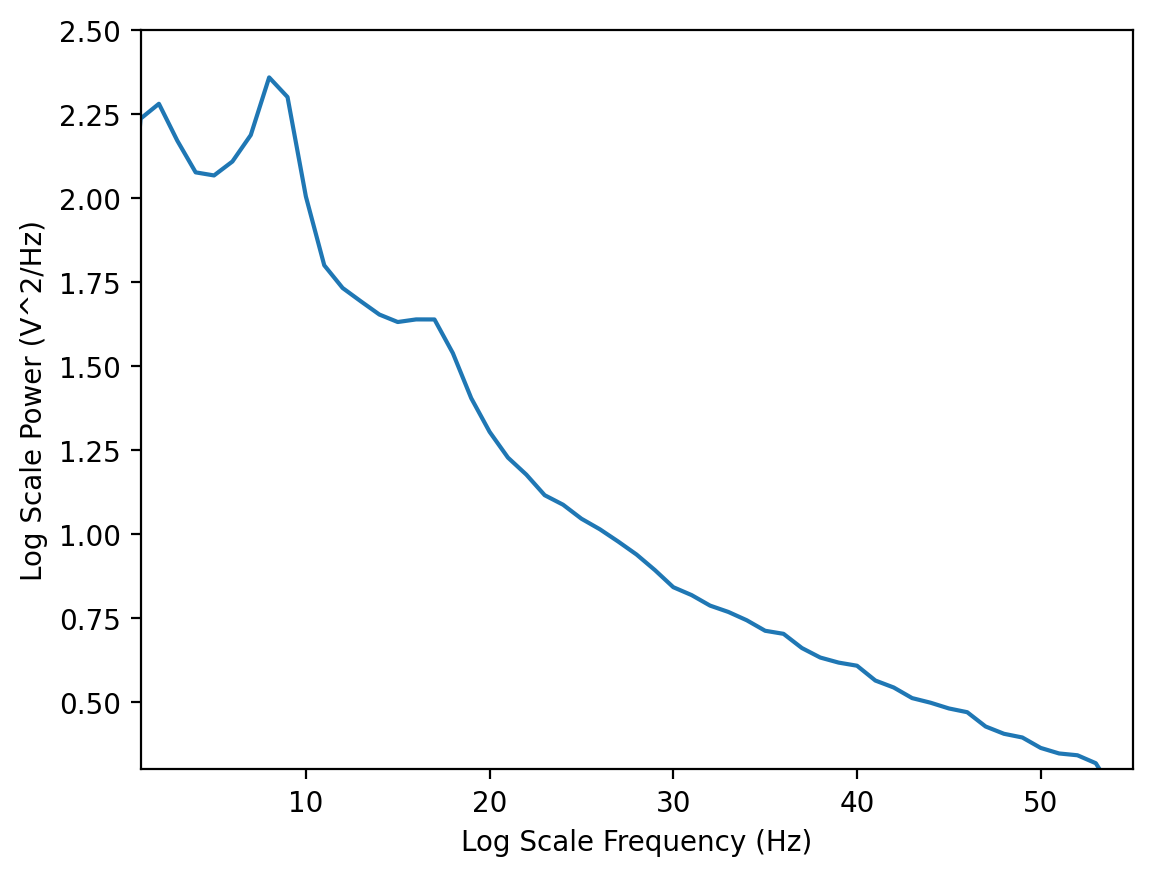

In [8]:
# Plot again, but log scale the power, zoom in below 60 Hz, and log scale the frequency axis

plt.plot(freq, np.log10(psd))
plt.xlabel('Log Scale Frequency (Hz)')
plt.ylabel('Log Scale Power (V^2/Hz)')
plt.xlim((1, 55))
plt.ylim((0.3, 2.5))
plt.show()

Now that's a beautiful power spectrum! Let's use the SpecParam (FOOOF) model to fit this power spectrum and extract some interesting parameters.

## Fit the SpecParam Model to your Power Spectrum

In [29]:
# **SAME SETTINGS AS SIMULATION NOTEBOOK**
# In this case, we set a peak width limit to be higher than 2 frequencies wide AND smaller than 8 frequencies wide.
# Furthermore, we're setting a hard threshold minimum for the peak height to be considered an oscillation.
specparam_sets = {'peak_width_limits': [2, 8], 'min_peak_height': 0.1}
freq_range = [1, 40] # Depending on the quality of your data, you might not want to fit very high frequencies

# Define the frequency ranges you consider to be alpha oscillations
alpha_range = [8, 12]

# Initialize models
model = FOOOF(**specparam_sets)

# Fit models
model.fit(freq, psd, freq_range=freq_range)

                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                        The model was run on the frequency range 1 - 40 Hz                        
                                 Frequency Resolution is 1.00 Hz                                  
                                                                                                  
                            Aperiodic Parameters (offset, exponent):                              
                                          2.5465, 1.1505                                          
                                                                                                  
                                       2 peaks were found:                                        
          

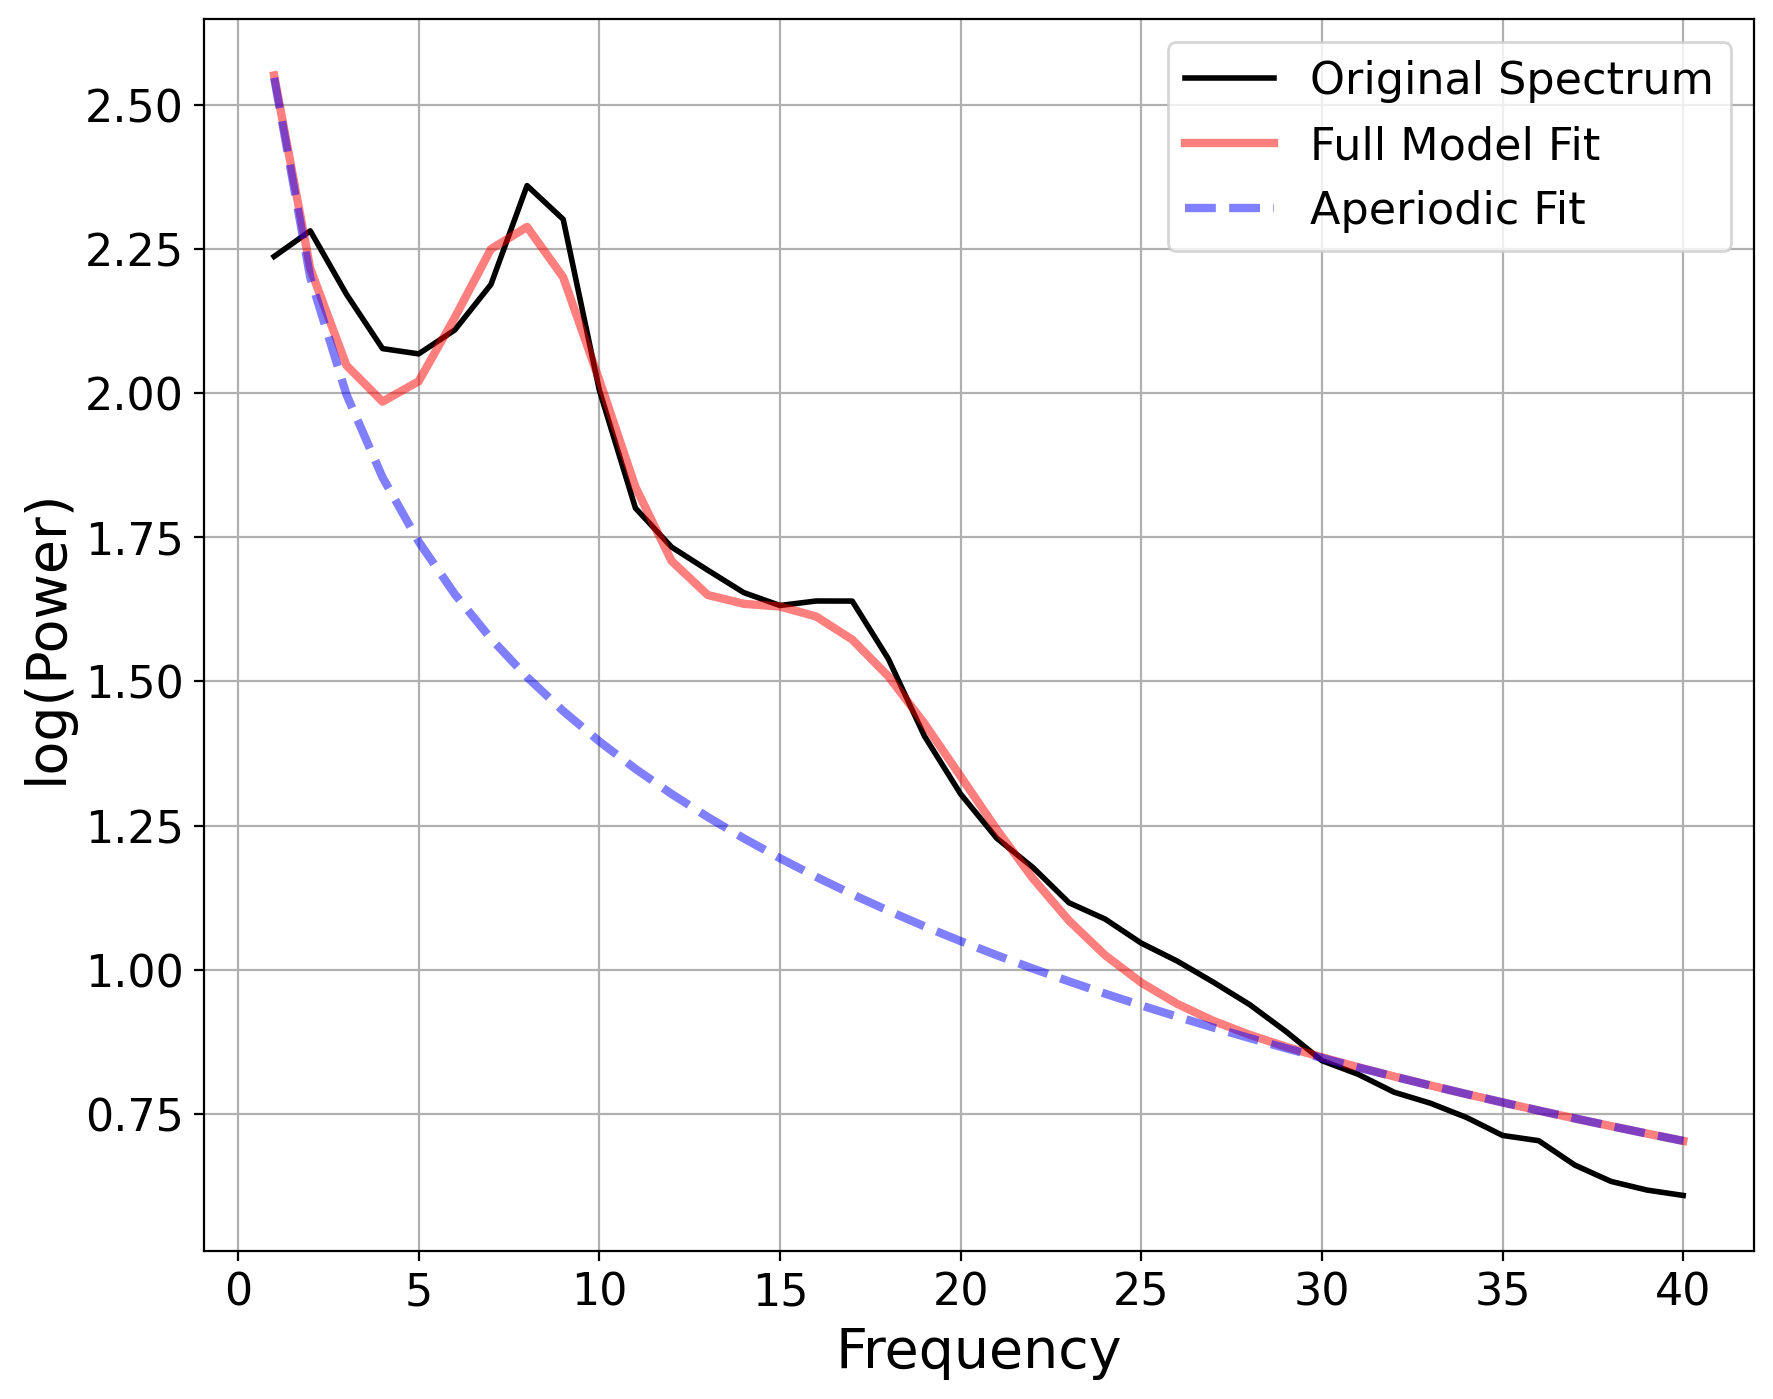

In [30]:
model.report()

## Extract Parameters for Analyses

In [11]:
# Extract the aperiodic parameters (exponent and offset)
aper = model.get_params('aperiodic_params')

# Extract the periodic paramaters (center frequency, aperidic adjusted power, band width)
per = model.get_params('peak_params')

In [32]:
# Print out model fit results
print('\033[1m' + 'Aperiodic parameters:' + '\033[0m' + '\n \t The aperiodic exponent (slope) is:', round(aper[0],3))
print('\t The aperiodic offset is:', round(aper[1],3))
print('\033[1m' + 'Periodic parameters:' + '\033[0m' + '\n \t There are ' + str(model.n_peaks_) + ' peaks found in this model.')

for idx, peak in enumerate(per):
    print('\t Peak #', str(idx+1))
    print('\t \t The center frequency is ' + str(round(peak[0],3)))
    print('\t \t The aperiodic adjusted power is ' + str(round(peak[1],3)))
    print('\t \t The bandwidth is ' + str(round(peak[2],3)))

Aperiodic parameters:
 	 The aperiodic exponent (slope) is: 2.547
	 The aperiodic offset is: 1.151
Periodic parameters:
 	 There are 2 peaks found in this model.
	 Peak # 1
	 	 The center frequency is 8.07
	 	 The aperiodic adjusted power is 0.781
	 	 The bandwidth is 4.358
	 Peak # 2
	 	 The center frequency is 16.178
	 	 The aperiodic adjusted power is 0.451
	 	 The bandwidth is 8.0


As you can see, there are two aperiodic parameters. The first parameter is the exponent, or slope, of the aperiodic signal. The second is the offset, which is the overall up/down transition of the whole power spectrum.

There are also three periodic parameters for each peak detected in the spectrum. The first parameter is the center frequency of each peak measured in frequency, the second parameter is the power of each peak (which is adjusted for the aperiodic signal) measured in power, and the third parameter is the bandwidth of each peak measured in frequency.

## Event-Related Power Spectrum Differences

Although it is interesting to look at the overall power spectrum and see the prominent alpha oscillations, it makes sense to look at event-related differences when there is a task involved. 

As we discussed at the beginning of this notebook, this ECoG subject is responding to visual stimuli and pressing a button if it is considered a target. Therefore, we can epoch our data into trials based on each event and average the trials based on event type. In the plot below, we will do this, and plot what is called an event-related potential (ERP) and compare the standard vs. target trials.

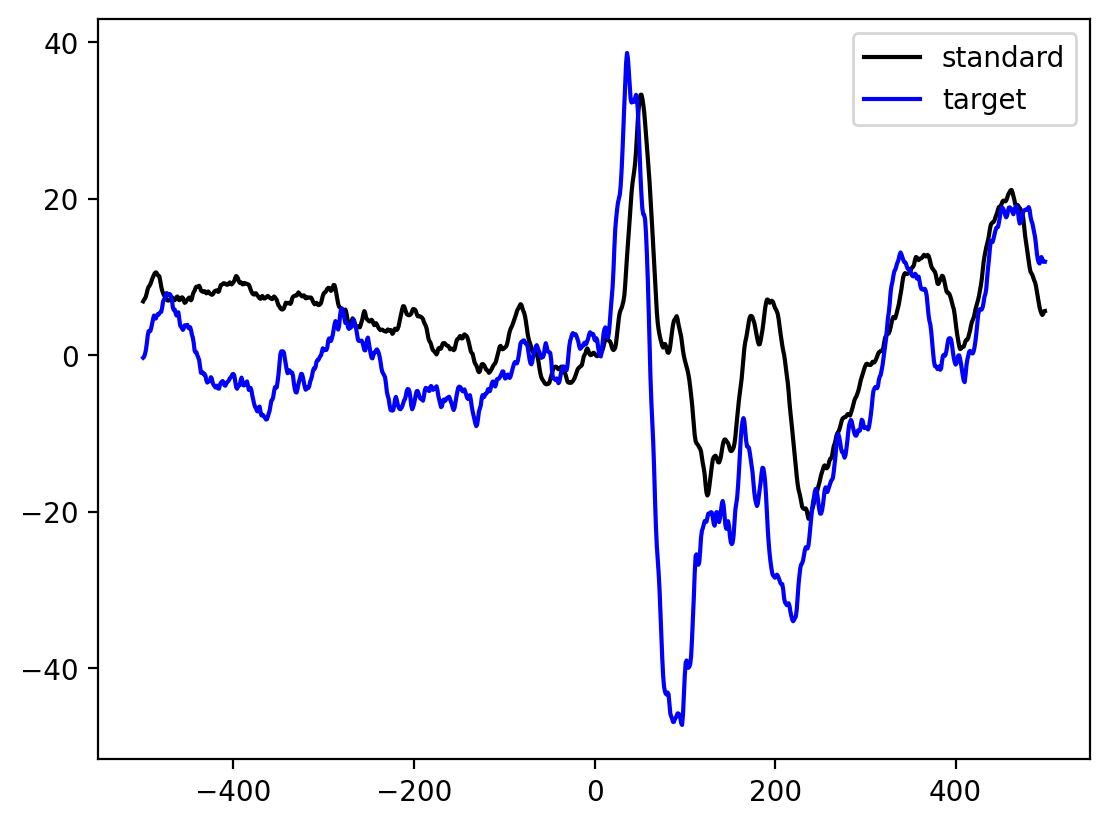

In [13]:
def event_related(data, fs, indices, window, subtract_mean=None):
    """Take an input time series, vector of event indices, and window sizes,
    and return a 2d matrix of windowed trials around the event indices.
    
    Parameters
    ----------
    data : array-like 1d
        Voltage time series
    data : float
        Data sampling rate (Hz)
    indices : array-like 1d of integers
        Indices of event onset indices
    window : tuple (intengers)
        Window (in ms) around event onsets
    subtract_mean : tuple (intengers), optional
        if present, subtract the mean value in the subtract_mean window for each
        trial from that trial's time series (this is a trial-by-trial baseline)
    
    Returns
    -------
    event_related_matrix : array-like 2d
        Event-related times series around each index
        Each row is a separate event
    """
    
    # convert times (in ms) to indices of points along the array
    def windows_to_indices(fs, window_times):
        conversion_factor = (1/fs)*1000 # convert from time points to ms
        window_times = np.floor(np.asarray(window_times)/conversion_factor) # coonvert
        window_times = window_times.astype(int) # turn to ints
        
        return window_times
    
    window_idx = windows_to_indices(fs, window) # convert times (in ms) to indices
    inds = indices + np.arange(window_idx[0],window_idx[1])[:,None] # build matrix of indices
    event_times = np.arange(window[0], window[1], fs/1000)
    
    event_related_matrix = data[inds] # grab the data
    event_related_matrix = np.squeeze(event_related_matrix).T # make sure it's in the right format
    
    # baseline, if requested
    if subtract_mean is not None:
        basewin = [0,0]
        basewin[0] = np.argmin(np.abs(event_times-subtract_mean[0]))
        basewin[1] = np.argmin(np.abs(event_times-subtract_mean[1]))
        event_related_matrix = event_related_matrix - event_related_matrix[:, basewin[0]:basewin[1]].mean(axis=1, keepdims=True)
    
    return event_times, event_related_matrix

event_times, sta_erp = event_related(data, fs, sta, (-500,500), (-100,0))
event_times, tar_erp = event_related(data, fs, tar, (-500,500), (-100,0))

plt.plot(event_times, np.mean(sta_erp,0), 'k', label='standard')
plt.plot(event_times, np.mean(tar_erp,0), 'b', label='target')
plt.legend()
plt.show()

From this plot, it looks like the onset of the target and standard stimuli produce a large event-related potential (ERP) and that these ERPs might differ depending on the experimental condition. However, when we think about the contributions of aperiodic activity to neural signals, there are several questions that might arise. For instance:

1) Does aperiodic activity change in an event-related way?

2) How might changes in aperiodic activity be affecting our interpretations of event-related changes in band power?

3) Could aperiodic activity be changing differentially according to behavioral condition?

To quantify this, we'll start with a basic pre- vs. post- event analysis. We'll divide the data into two windows--2 seconds pre-event onset, and 2 seconds post-event onset--, calcualte power spectra for these two windows, and compare spectral features.

In [14]:
# compute event windows with no baseline
event_times, pre_sta_erp = event_related(data, fs, sta, (-1*fs,0))
event_times, post_sta_erp = event_related(data, fs, sta, (0,1*fs))
event_times, pre_tar_erp = event_related(data, fs, tar, (-1*fs,0))
event_times, post_tar_erp = event_related(data, fs, tar, (0,1*fs))

In [15]:
# caclculate power spectra for 2 time windows and 2 conditions
freqs, pre_sta_psd = spectral.compute_spectrum_welch(pre_sta_erp, fs, nperseg=fs*1, noverlap=fs/2, f_range=[2,52])
freqs, post_sta_psd = spectral.compute_spectrum_welch(post_sta_erp, fs, nperseg=fs*1, noverlap=fs/2, f_range=[2,52])
freqs, pre_tar_psd = spectral.compute_spectrum_welch(pre_tar_erp, fs, nperseg=fs*1, noverlap=fs/2, f_range=[2,52])
freqs, post_tar_psd = spectral.compute_spectrum_welch(post_tar_erp, fs, nperseg=fs*1, noverlap=fs/2, f_range=[2,52])

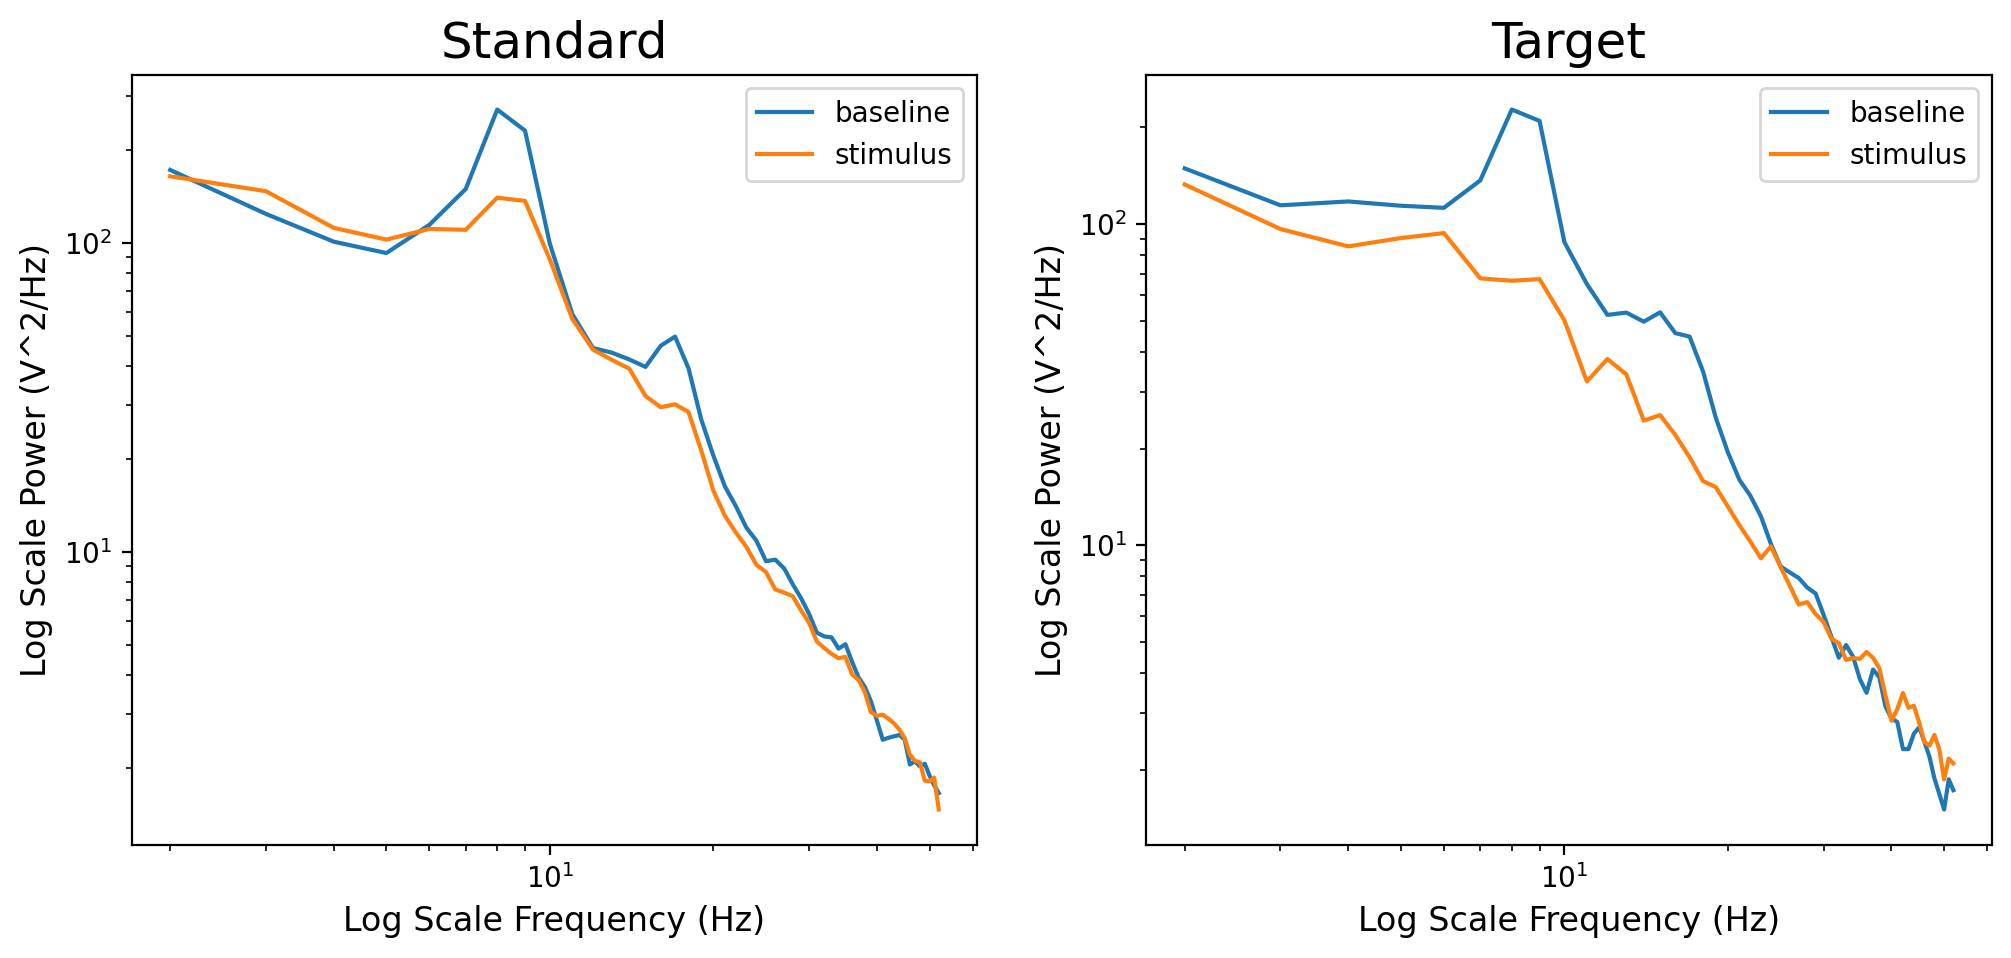

In [16]:
# plot raw psds

fig, ax = plt.subplots(1,2, figsize=[12,5])
ax = ax.ravel()

ax[0].plot(freqs, pre_sta_psd.mean(axis=0), label='baseline')
ax[0].plot(freqs, post_sta_psd.mean(axis=0), label='stimulus')

ax[1].plot(freqs, pre_tar_psd.mean(axis=0), label='baseline')
ax[1].plot(freqs, post_tar_psd.mean(axis=0), label='stimulus')

ax[0].set_title('Standard', fontsize=18)
ax[0].set_xlabel('Log Scale Frequency (Hz)', fontsize=12)
ax[0].set_ylabel('Log Scale Power (V^2/Hz)',  fontsize=12)
ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[0].legend();
ax[1].set_title('Target', fontsize=18)
ax[1].set_xlabel('Log Scale Frequency (Hz)',  fontsize=12)
ax[1].set_ylabel('Log Scale Power (V^2/Hz)', fontsize=12)
ax[1].set_xscale('log')
ax[1].set_yscale('log')
ax[1].legend();

### Like ERP analysis, these power spectra have been averaged across trials, but let's take a look at it on a trial by trial basis using **FOOOFGroup**

In [17]:
# In this case, we set a peak width limit to be higher than 2 frequencies wide AND smaller than 8 frequencies wide.
# Furthermore, we're setting a hard threshold minimum for the peak height to be considered an oscillation.
specparam_sets = {'peak_width_limits': [2, 8], 'min_peak_height': 0.1}
freq_range = [1, 40]

# Define the frequency ranges you consider to be theta or alpha oscillations
alpha_range = [8, 12]

# Initialize models
pre_sta_model = FOOOFGroup(**specparam_sets)
post_sta_model = FOOOFGroup(**specparam_sets)

# Fit models
pre_sta_model.fit(freqs, pre_sta_psd, freq_range=freq_range)
post_sta_model.fit(freqs, post_sta_psd, freq_range=freq_range)

Running FOOOFGroup across 380 power spectra.
Running FOOOFGroup across 380 power spectra.


## Inspecting the model fits

Using the plot() command, we can inspect the model fits. SpecParam automatically calculates the model fit in 2 different measurements: 1) Error, 2) Rˆ2.

This plot will also show you all aperiodic fits and the center frequencies of the peaks it found.

We highly encourage you to always plot these figures, because they give you an initial glance at how accurate the model fits the data.

### Pre-Stimulus period FOOOFGroup

/Users/sydneysmith/opt/anaconda3/lib/python3.9/site-packages/fooof/objs/group.py:378: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  out = np.array([np.insert(getattr(data, name), 3, index, axis=1)


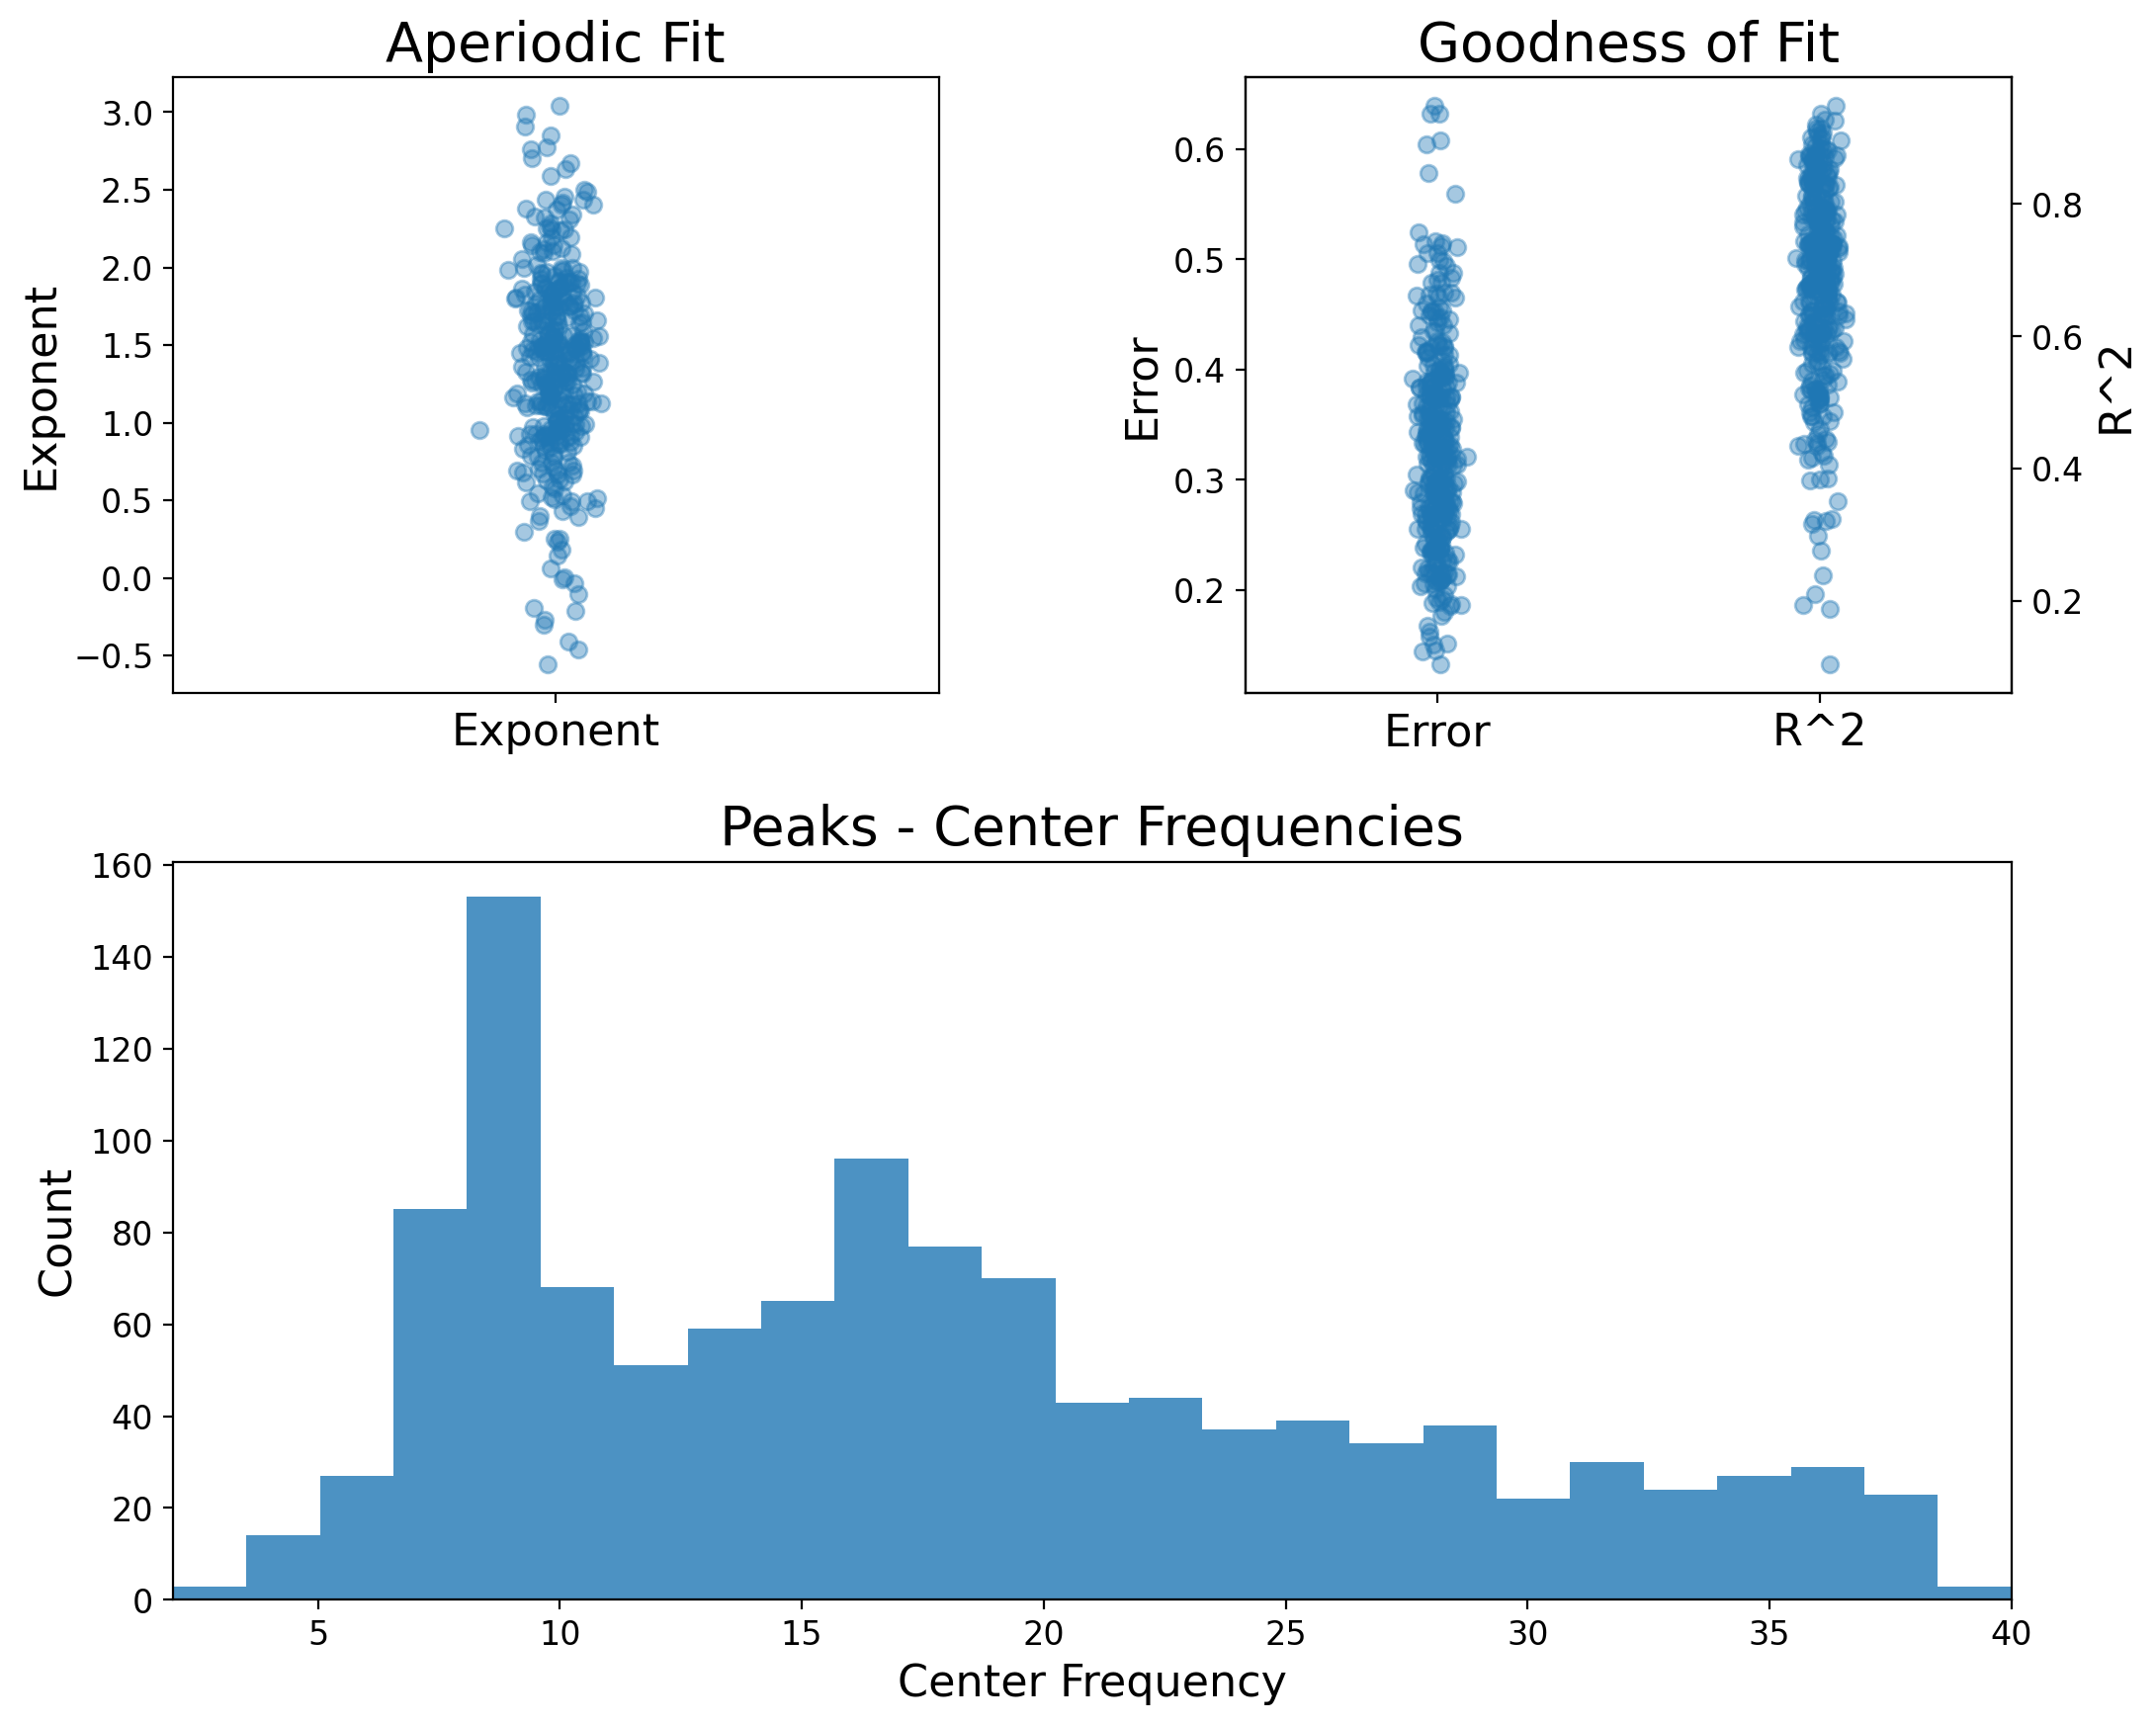

In [35]:
pre_sta_model.plot()

### Post-stimulus period FOOOFGroup

/Users/sydneysmith/opt/anaconda3/lib/python3.9/site-packages/fooof/objs/group.py:378: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  out = np.array([np.insert(getattr(data, name), 3, index, axis=1)


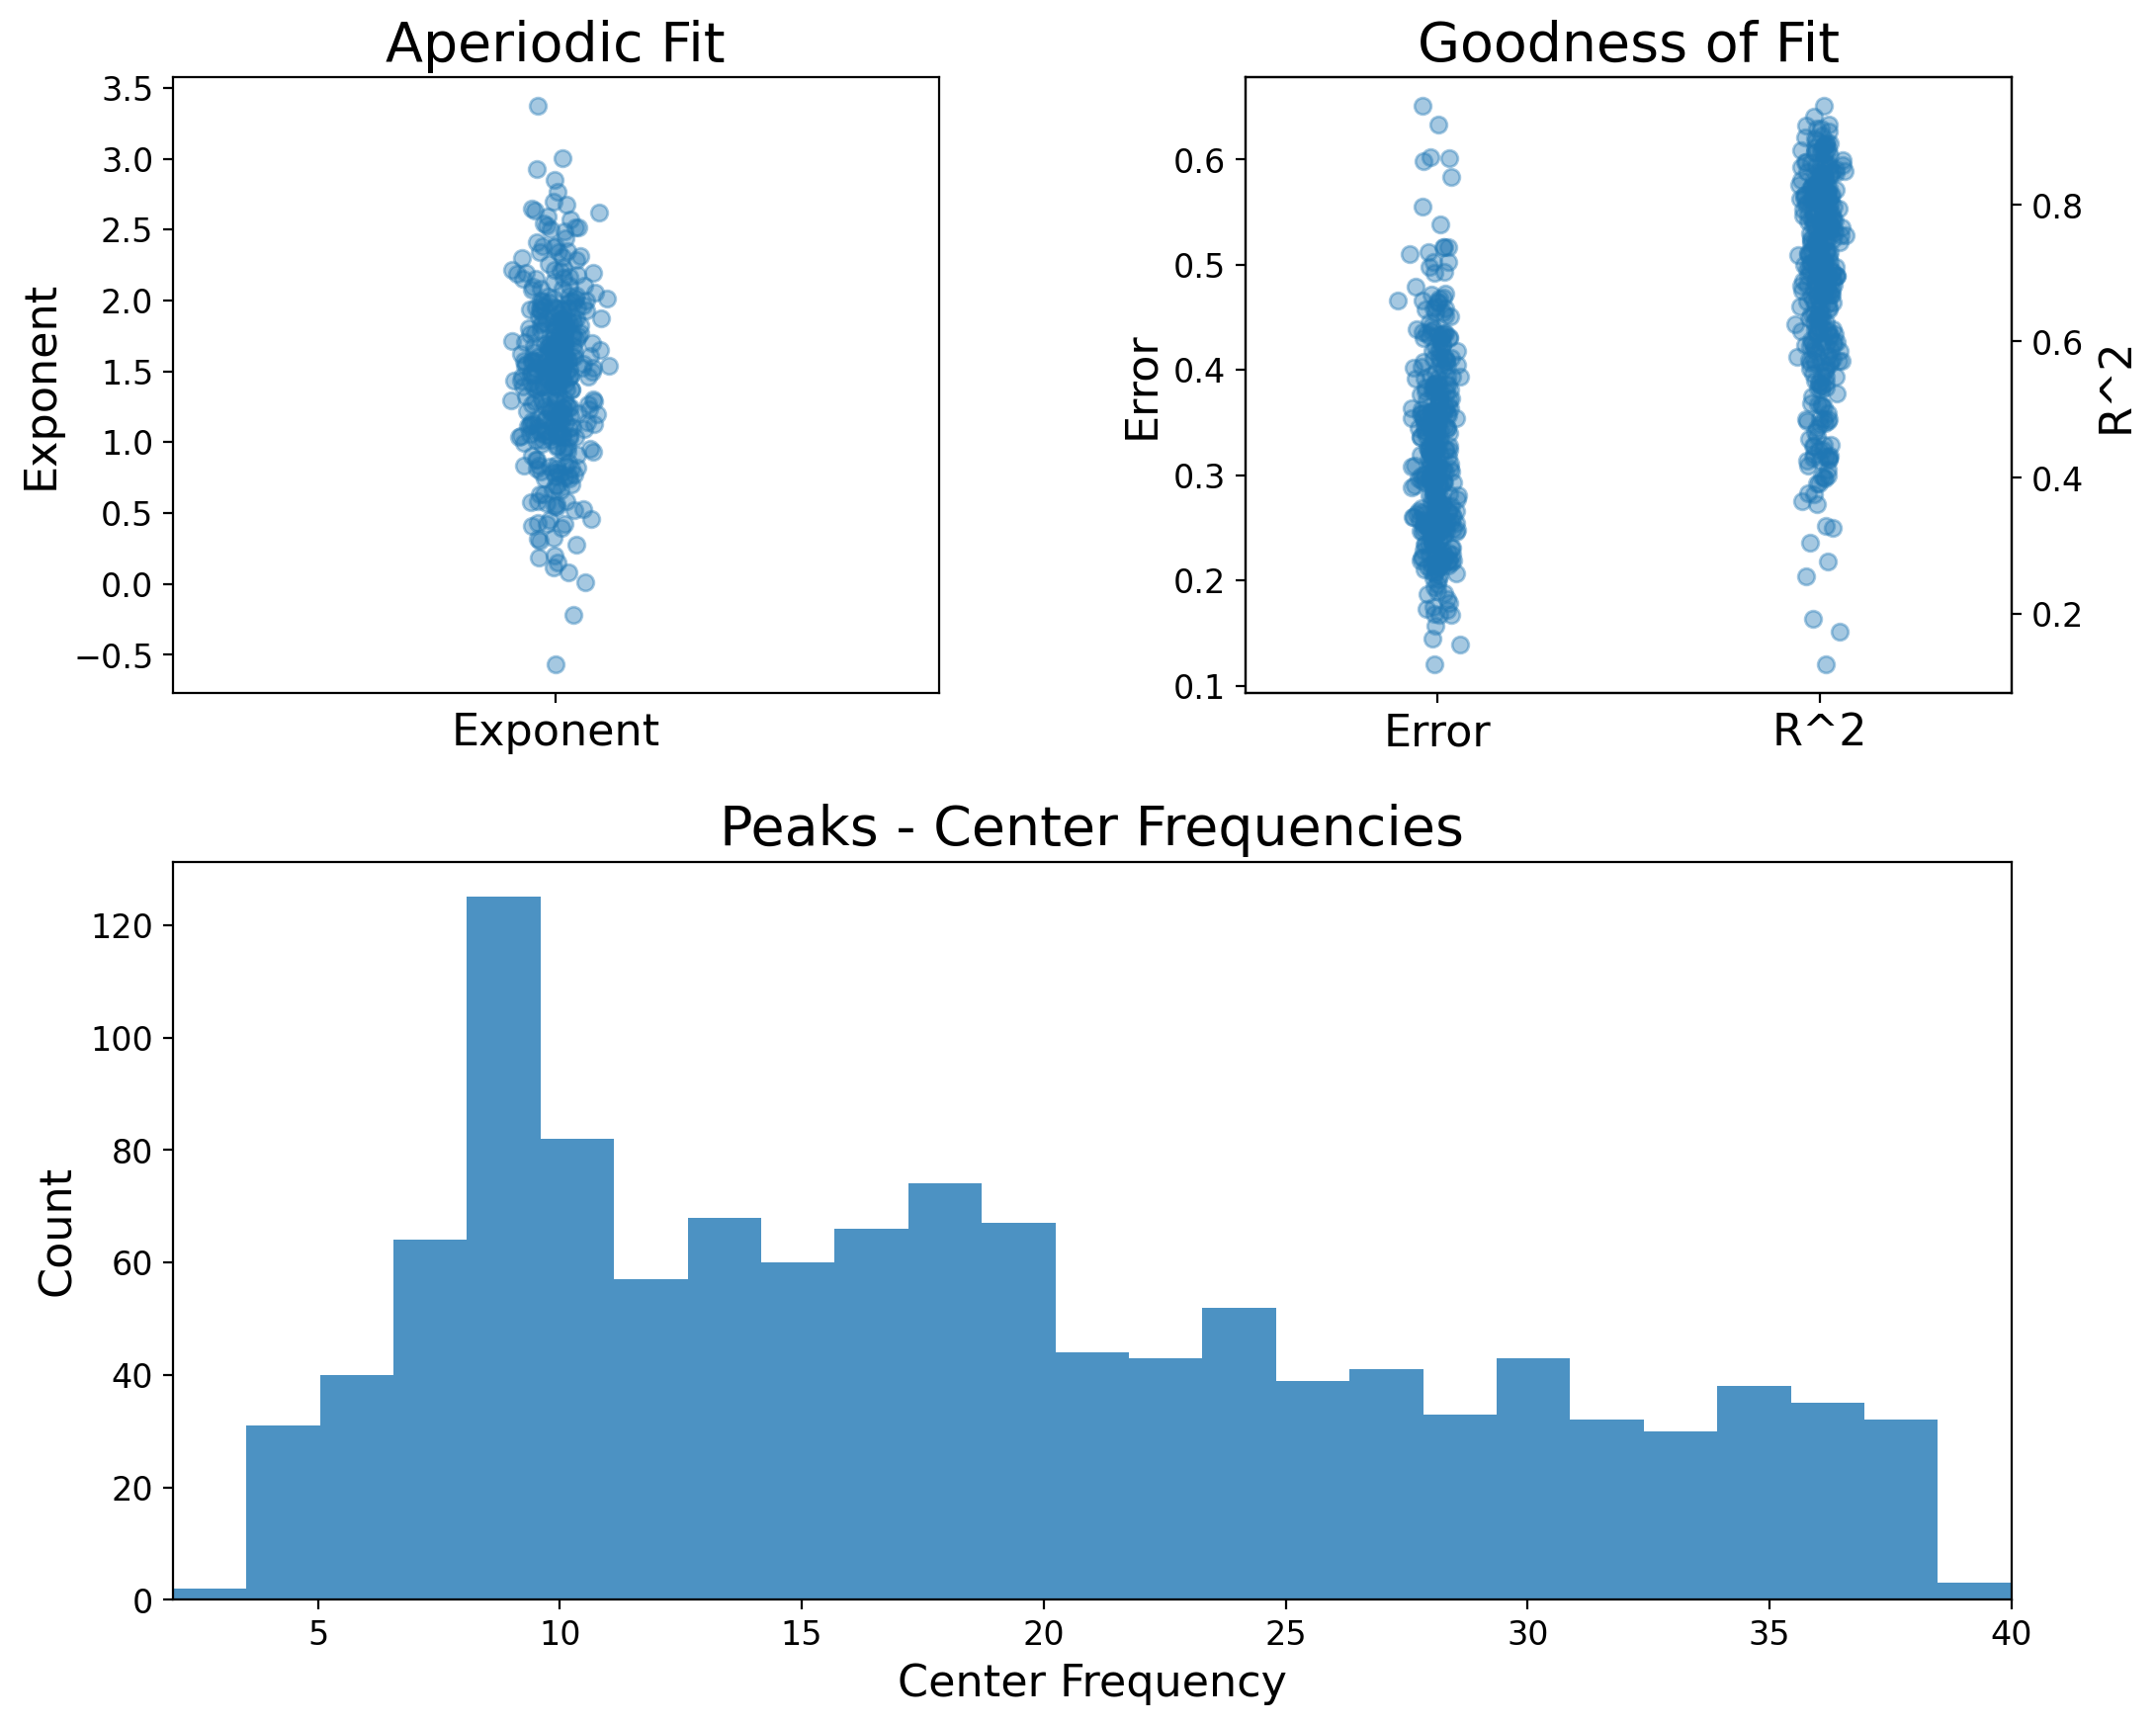

In [36]:
post_sta_model.plot()

What do you notice about the goodness of fit metrics?

What about this data might be causing the higher error?

### Extract and look at the parameters

In [37]:
# Extract the aperiodic parameters (exponent and offset)
exp_pre_sta = pre_sta_model.get_params('aperiodic_params', 'exponent')
exp_post_sta = post_sta_model.get_params('aperiodic_params', 'exponent')
offset_pre_sta = pre_sta_model.get_params('aperiodic_params', 'offset')
offset_post_sta = post_sta_model.get_params('aperiodic_params', 'offset')

# Extract the periodic paramaters (aperidic adjusted power, band width, center frequency)
alpha_pre_sta = get_band_peak_fg(pre_sta_model, band=alpha_range)
alpha_post_sta = get_band_peak_fg(post_sta_model, band=alpha_range)

In [38]:
# Let's see what our parameters look like. We have a list of all the exponents for the  pre stimulus standard trials
exp_pre_sta

array([ 1.20256745,  1.63237293,  1.11908057,  1.28783561,  0.63022139,
        1.57145706,  1.365203  ,  0.91744778,  1.31381915,  1.40929311,
        1.51073696,  0.9561707 ,  1.26799718,  1.48378131,  1.51635171,
        0.23268847,  0.8597073 ,  1.1245863 ,  0.4951536 ,  2.38165244,
        0.85378088,  1.9946274 ,  0.53133078,  1.68506627,  1.00343428,
        2.28493698,  0.98968705,  1.55498879,  1.54191292,  0.49684031,
        1.13880291,  1.46173031,  1.31825475,  1.62920524,  1.12504566,
       -0.41231155,  0.14314267,  2.66990666,  0.59008366,  1.32264109,
        0.50664826,  1.83966131,  0.81130971,  1.86882215,  1.44928466,
        1.32950936,  1.46450268,  0.98852089,  1.31554372,  2.1218078 ,
        1.41663503,  1.89556298,  2.01495872,  1.78303719,  0.18518752,
        1.67586548,  2.26333719,  0.69302714,  2.05438408,  1.79083973,
        0.98129994,  1.88827323,  1.3316224 ,  1.49434201,  0.665293  ,
        2.16188338,  1.24889666,  1.47983872,  2.90431001,  2.49

In [39]:
# Let's look at the alpha parameters of the pre stimulus standard trials.
# Here we see 3 columns and rows with the same amount as trials. 
# Look up the 'get_band_peak_fg' to see which parameter is which column ---> SPOILER:  [CF, PW, BW]
alpha_pre_sta

array([[ 9.08305603,  1.10736688,  2.34420095],
       [10.78743143,  1.20307086,  7.79744675],
       [ 9.85885642,  1.3487373 ,  2.        ],
       ...,
       [10.20139509,  0.96979242,  2.        ],
       [10.12349235,  0.98102224,  3.95285948],
       [ 8.31933826,  2.0239373 ,  2.        ]])

## Lastly, let's plot some of the differences in parameters between condition 1 and 2

In [40]:
# plotting function

def plot_feature_conditions(feature_c1, feature_c2):
        
    x1 = np.ones(len(feature_c1)) * 0.5
    x2 = np.ones(len(feature_c2)) * 1.5
    plt.scatter(x1+np.random.normal(-0.025,0.025,len(feature_c1)), feature_c1, color='teal', alpha=0.3)
    plt.scatter(x2+np.random.normal(-0.025,0.025,len(feature_c2)), feature_c2, color='orange', alpha=0.3)

    plt.plot([x1-0.1, x1+0.1], [np.nanmean(feature_c1), np.nanmean(feature_c1)], lw=7, c='teal')
    plt.plot([x2-0.1, x2+0.1], [np.nanmean(feature_c2), np.nanmean(feature_c2)], lw=7, c='orange')

    plt.xlim([0, 2])

    plt.xticks([x1[0], x2[0]], ["pre-stimulus", "post-stimulus"])


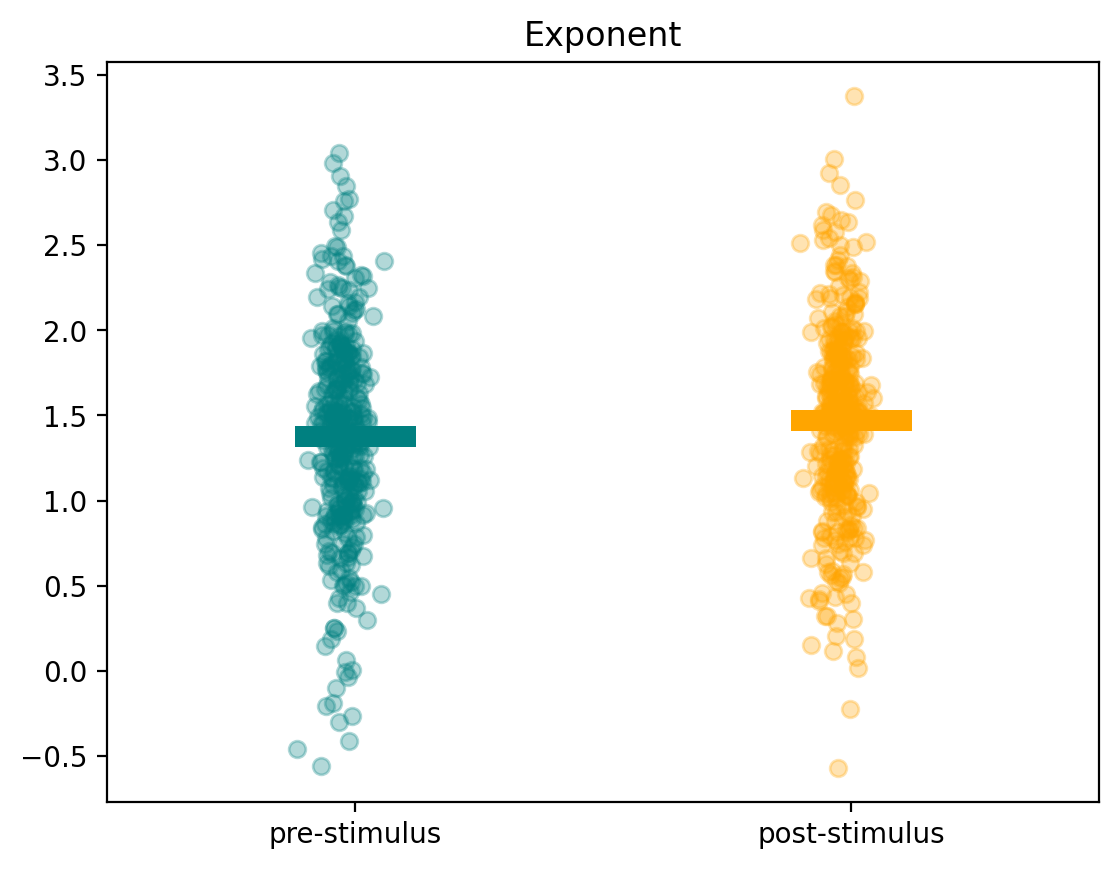

In [41]:
plot_feature_conditions(exp_pre_sta, exp_post_sta)
plt.title('Exponent');

To the naked eye, it doesn't look like there is much difference between these two conditions in terms of their aperiodic exponent, but we would need to run a statistical test to say for sure.

In [25]:
# To select the alpha aperiodic adjusted power, select all rows from column 2
alpha_pw_pre_sta = alpha_pre_sta[:,1]
alpha_pw_post_sta = alpha_post_sta[:,1]

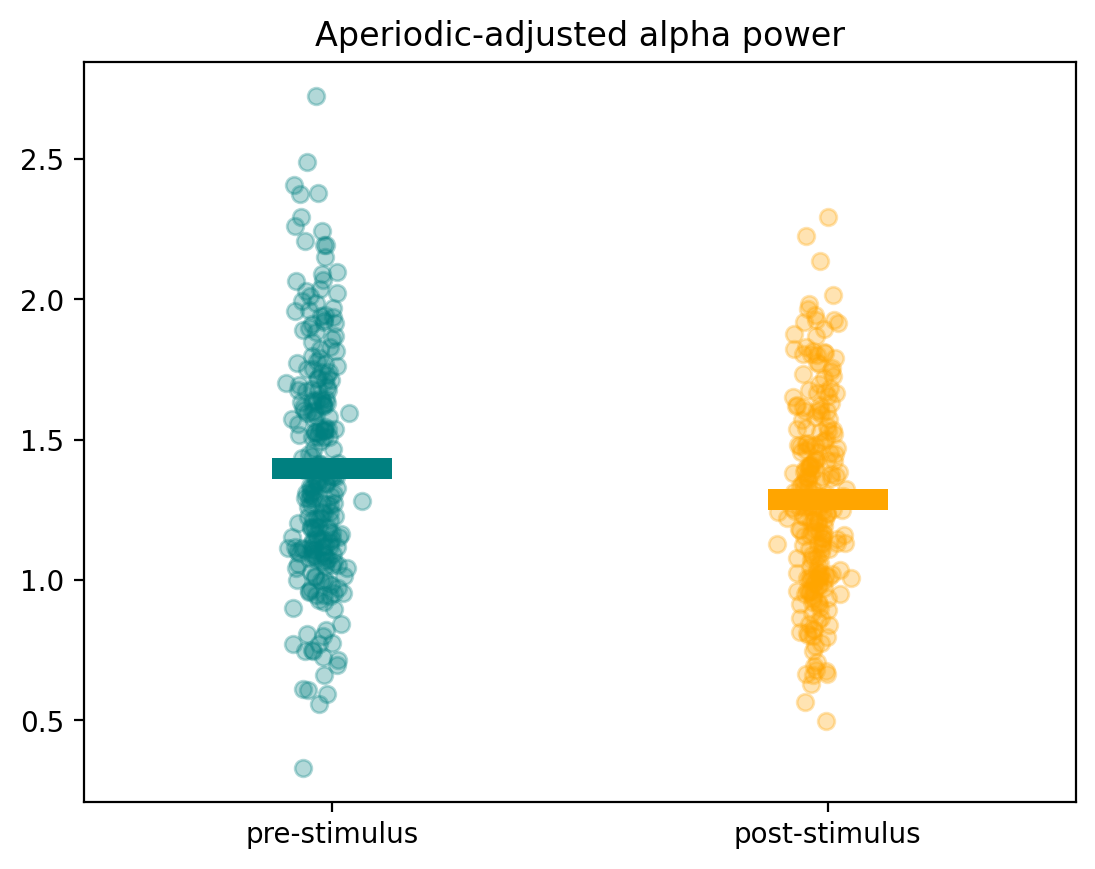

In [26]:
plot_feature_conditions(alpha_pw_pre_sta, alpha_pw_post_sta)
plt.title('Aperiodic-adjusted alpha power');

In [27]:
# To select the alpha center frequency, select all rows from column 1
alpha_cf_pre_sta = alpha_pre_sta[:,1]
alpha_cf_post_sta = alpha_post_sta[:,1]

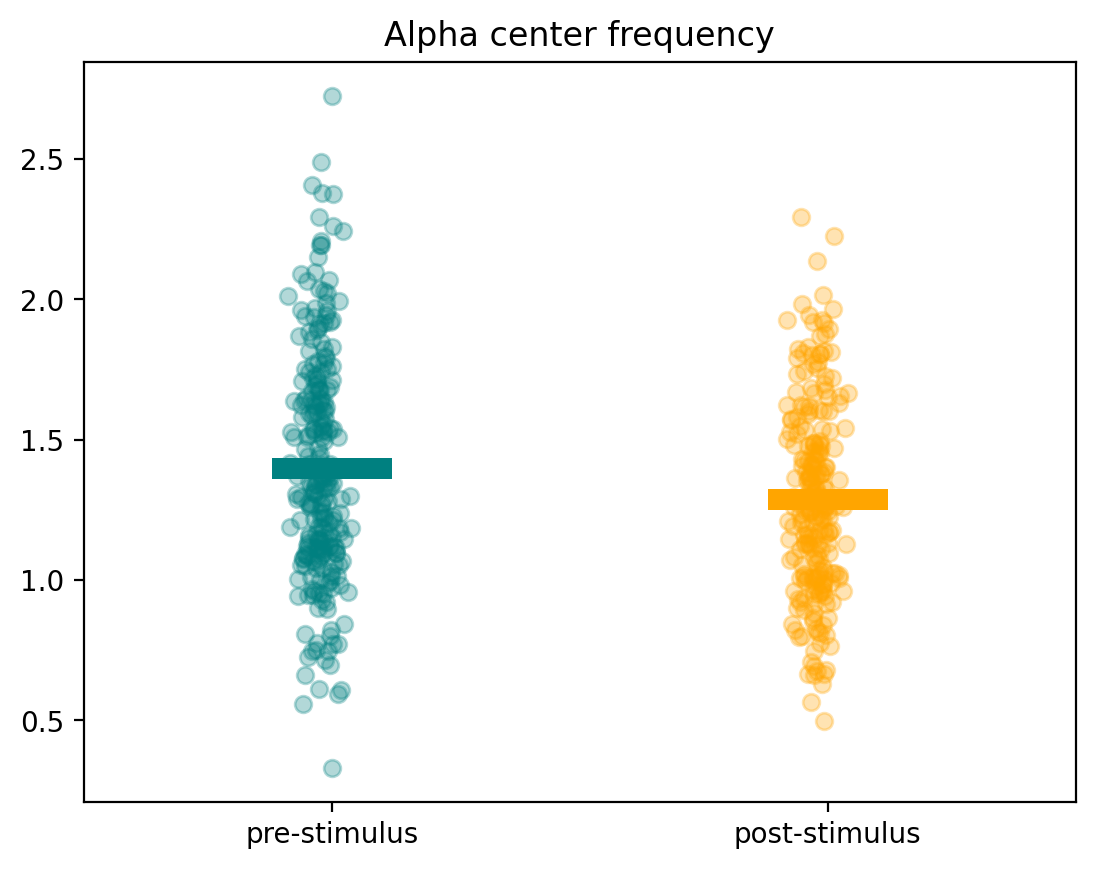

In [28]:
plot_feature_conditions(alpha_cf_pre_sta, alpha_cf_post_sta)
plt.title('Alpha center frequency');

For now, we've only looked at canonical alpha. Is there another frequency range that could be of interest in this analysis based on the power spectra, and the peaks found using FOOOFGroup?

If so, try to implement this yourself!

#### This notebook contains a lot of functions that make FOOOF results easier to work with (like extracting parameters from model fits). Explore them yourself on the [FOOOF documentation website](https://fooof-tools.github.io/fooof/api.html).